In [1]:
import psycopg2
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [2]:
#postgresql 접속
conn_string = "host='localhost' dbname='postgres' user='postgres' password='admin'"
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

#데이터 가져오기
cur.execute("select distinct title, date, url, hashtag from yt_clothes")
conn.commit()
yy = cur.fetchall()

#DF화
yyy = pd.DataFrame(yy)
yyy.columns = ['title', 'date', 'url', 'hashtag']

#db 연결 종료
conn.cursor().close()
conn.close()

In [3]:
yyy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16596 entries, 0 to 16595
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    16596 non-null  object
 1   date     16596 non-null  object
 2   url      16596 non-null  object
 3   hashtag  16596 non-null  object
dtypes: object(4)
memory usage: 518.8+ KB


In [4]:
#yyy 데이터 20%만 샘플링
yyy = yyy.sample(3200)

#csv로 저장 후 class 열 눈코딩
yyy.to_csv('./outputs/yt_clothes_sample.csv', encoding='utf-8-sig')

In [2]:
# class 추가된 데이터 가져오기
df = pd.read_csv('./outputs/yt_clothes_class.csv', encoding='cp949')
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,title,date,url,hashtag,class
0,"행복여 | 블록 레터링 루즈핏 봄 맨투맨 티셔츠 | 15,600원 | 라이브방송 |...",2022-03-21,https://www.youtube.com/shorts/jdIctLzCWxA,NaN,1
1,FALL LOOKBOOK / 03년생 / 모자추천 / 가을룩북 ㅇㅈㄹ,2021-09-21,https://www.youtube.com/watch?v=EOTGHHoRp2w,NaN,1
2,"존.예 겨울 원피스 하울~♥? 이쁘고 편한것만 골라와쏘?? (연말룩,하객룩,겨울코디)",2021-11-28,https://www.youtube.com/watch?v=DgZa_ttSqY8,#원피스하울 #겨울원피스 #겨울패션하울,1
3,가디건 이것만 알면 끝! - 가격대별 필수 가디건 추천 [코스/엘무드/일꼬르소/네이...,2022-03-17,https://www.youtube.com/watch?v=mpQEPl0qTiU,NaN,1
4,15분 초간단? 꾸안꾸 데일리 메이크업+스킨케어??,2022-02-05,https://www.youtube.com/watch?v=dNIHZPYP45A,#왕초보메이크업 #데일리메이크업 #화장잘먹는법,0


(array([ 289.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2911.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

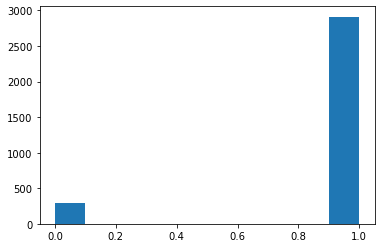

In [101]:
plt.hist(df['class'])

In [3]:
# 영향을 주지 않는 열 지우기
dff = df.drop(['date', 'url'], axis=1)

# 해시태그가 없는 열은 공백으로 채우기
dff = dff.fillna('')

# 종속변수, 독립변수 분리
dff_x = dff['title']
dff_y = dff['class']

In [4]:
# 데이터셋 분리
X_train, X_test, y_train, y_test = train_test_split(dff_x, dff_y, test_size=0.3, random_state=25)

# 훈련 데이터 오버샘플링
oversample = RandomOverSampler(sampling_strategy='minority')

#샘플러에 들어가기 위해 array 타입으로 바꾸기
X_np_train = np.array(X_train) 
X_np_train = np.reshape(X_np_train, (len(X_train), 1))
y_np_train = np.array(y_train)

# resample
X_sample_train, y_sample_train = oversample.fit_resample(X_np_train, y_np_train)

# 다시 시리즈 형태로 만들어주기
X_list_train = X_sample_train.tolist() # type(X_list_train[0]) : list
X_train = []
for i in range(len(X_list_train)) :
    X_train.append(X_list_train[i][0])
X_train = pd.Series(X_train)
#X_train = list(chain.from_iterable(X_train))
y_train = pd.Series(y_sample_train.tolist())

In [86]:
print(len(X_train), len(y_train), len(X_test), len(y_test))

4048 4048 960 960


In [5]:
X = pd.concat([X_train, X_test], axis = 0)
y = pd.concat([y_train, y_test], axis = 0)

In [6]:
# count vectorizer
cv = CountVectorizer()
X = cv.fit_transform(X) #fit the data

X.toarray()

# 정확도 90.52% 근데 이제 거짓을 거짓이라 예측하는게 42% 밖에 안돼

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [112]:
# tfidf vectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X) #fit the data

X.toarray()

# 정확도 92.40% 근데 이제 모든 값을 관련있다고 예측하는,,,

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
X_train = X[:4048]
X_test = X[4048:]
y_train = y[:4048]
y_test = y[4048:]

In [8]:
# 나이브 베이즈 분류모델
clf = MultinomialNB()
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

# 정확도
print(" Accuracy of Model : {:.2f}%".format(clf.score(X_test,y_test)*100))

# 혼동행렬
predictions = clf.predict(X_test)
print(classification_report(y_test, predictions))


 Accuracy of Model : 90.94%
              precision    recall  f1-score   support

           0       0.44      0.71      0.54        73
           1       0.98      0.93      0.95       887

    accuracy                           0.91       960
   macro avg       0.71      0.82      0.75       960
weighted avg       0.93      0.91      0.92       960



precision(정밀도) : 참 예측 중에서 진짜 참인 친구  
recall(재현율) : 진짜 참 중에서 예측 참인 친구  
f1-score : 정밀도+재현율, 둘다 고를 때 높게 나타남  


스팸메일 분류 모델은 거짓인 모델을 참으로 예측했을때 영향을 줌 >> [0,recall]값이 높아야


In [68]:
# test
comment = '브이로그 겨울 원피스 쇼핑'
vect = cv.transform([comment]).toarray()
clf.predict(vect)

if clf.predict(vect) == 1:
    print(comment, ': 관련있음')
else :
    print(comment, ': 관련없음')

# test2
comment = '관련없는 말'
vect = cv.transform([comment]).toarray()
clf.predict(vect)

if clf.predict(vect) == 1:
    print(comment, ': 관련있음')
else :
    print(comment, ': 관련없음')

브이로그 겨울 원피스 쇼핑 : 관련있음
관련없는 말 : 관련없음


In [83]:
import pickle

# 모델 저장
with open('NBmodel.pkl', 'wb') as f:
    pickle.dump(clf, f)

# 모델 로드
with open('NBmodel.pkl', 'rb') as f:
    model = pickle.load(f)

# 모델 사용
#comment = '천방지축 얼렁뚱땅 빙글빙글 돌아가는 짱구의하루'
comment = '올리브영 세일'
vect = cv.transform([comment]).toarray()
model.predict(vect)

if clf.predict(vect) == 1:
    print(comment, ': 관련있음')
else :
    print(comment, ': 관련없음')

올리브영 세일 : 관련있음
